## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [110]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [111]:
pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [112]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import swifter
from sklearn.feature_extraction.text import TfidfTransformer

from wordcloud import WordCloud, STOPWORDS
from collections import Counter

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
# Opening JSON file 
f =open('/content/drive/MyDrive/complaints-2021-05-14_08_16.json') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [115]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [116]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [117]:
#Assign new column names
df.rename(columns={'_source.complaint_what_happened':'complaints_what_happened', '_source.product':'tag'}, inplace=True)

In [118]:
#Assign nan in place of blanks in the complaints column
df['complaints_what_happened'].replace("", np.nan, inplace=True)
df['complaints_what_happened']

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaints_what_happened, Length: 78313, dtype: object

In [119]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaints_what_happened'], inplace=True)
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [120]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_data(text):
    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
    return text

In [121]:
#Write your function to Lemmatize the texts
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str


In [122]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({'complaints_what_happened':df['complaints_what_happened'], 'lemmatized':df['complaints_what_happened'].apply(lemmatization)})

In [123]:
df_clean

,complaints_what_happened,lemmatized
1,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card wa reported on XX/XX/2019 . However...
11,"On XX/XX/2018, while trying to book a XXXX XX...","On XX/XX/2018 , while trying to book a XXXX XX..."
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for { $ 1600.00 } i...
...,...,...
78303,After being a Chase Card customer for well ove...,After being a Chase Card customer for well ove...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","On Wednesday , XX/XX/XXXX I called Chas , my X..."
78310,I am not familiar with XXXX pay and did not un...,I am not familiar with XXXX pay and did not un...
78311,I have had flawless credit for 30 yrs. I've ha...,I have had flawless credit for 30 yr . I 've h...


In [124]:
#Write your function to extract the POS tags 

def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str



df_clean["complaint_POS_removed"] =   df_clean.swifter.apply(lambda x: get_pos_tags(x['lemmatized']), axis=1) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [125]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints_what_happened,lemmatized,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is XXXX XXXX and I apprec...,morning name xxxx xxxx stop cardmember service...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx xxxx card agent anniversary date agent in...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card wa reported on XX/XX/2019 . However...,application identity consent service credit id...
11,"On XX/XX/2018, while trying to book a XXXX XX...","On XX/XX/2018 , while trying to book a XXXX XX...",xx/2018 xxxx xxxx ticket offer ticket reward c...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for { $ 1600.00 } i...,son check chase account fund chase bank accoun...
...,...,...,...
78303,After being a Chase Card customer for well ove...,After being a Chase Card customer for well ove...,customer decade solicitation credit card bonus...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","On Wednesday , XX/XX/XXXX I called Chas , my X...",xxxx xxxx xxxx provider claim purchase protect...
78310,I am not familiar with XXXX pay and did not un...,I am not familiar with XXXX pay and did not un...,xxxx pay risk consumer bank app year banking m...
78311,I have had flawless credit for 30 yrs. I've ha...,I have had flawless credit for 30 yr . I 've h...,credit yr credit card xxxx problem balance tra...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




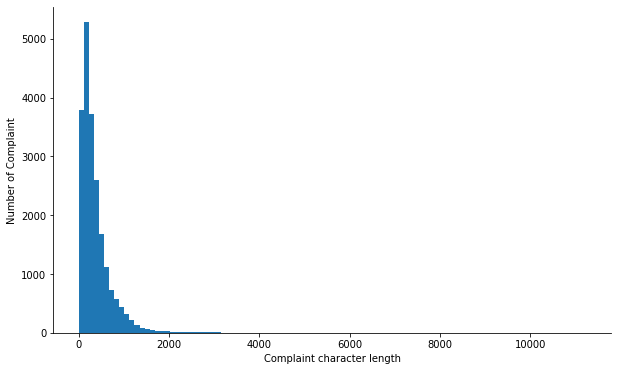

In [126]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

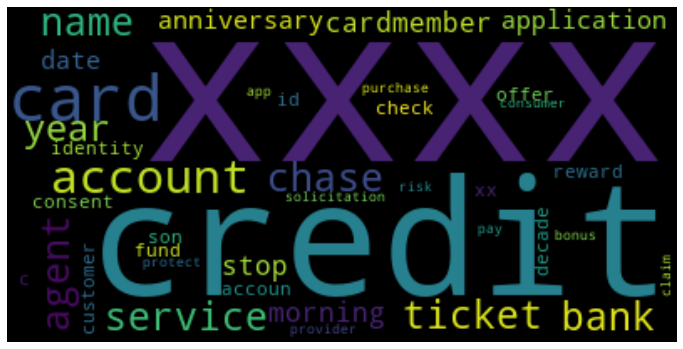

In [127]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [128]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [129]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [130]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,xxxx,169229
1,account,46736
2,credit,29532
3,card,27464
4,payment,20613
5,time,16089
6,bank,15458
7,day,12935
8,money,11939
9,charge,11931


In [131]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [132]:
#Print the top 10 words in the bigram frequency
top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,xxxx xxxx,74171
1,credit card,11279
2,account xxxx,5126
3,xxxx account,3960
4,credit report,3664
5,checking account,3317
6,xxxx credit,2993
7,account account,2873
8,card xxxx,2806
9,xxxx payment,2732


In [133]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [134]:
#Print the top 10 words in the trigram frequency
top_common_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,xxxx xxxx xxxx,40118
1,account xxxx xxxx,1641
2,xxxx xxxx account,1510
3,xxxx credit card,1493
4,credit card account,1038
5,credit card xxxx,1036
6,xxxx xxxx credit,980
7,payment xxxx xxxx,939
8,card xxxx xxxx,933
9,xxxx xxxx payment,912


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [135]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [136]:
#All masked texts has been removed
df_clean

,complaints_what_happened,lemmatized,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is XXXX XXXX and I apprec...,morning name xxxx xxxx stop cardmember service...,morning name stop cardmember service debt ve...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx xxxx card agent anniversary date agent in...,card agent anniversary date agent informatio...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card wa reported on XX/XX/2019 . However...,application identity consent service credit id...,application identity consent service credit id...
11,"On XX/XX/2018, while trying to book a XXXX XX...","On XX/XX/2018 , while trying to book a XXXX XX...",xx/2018 xxxx xxxx ticket offer ticket reward c...,xx/2018 ticket offer ticket reward card info...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for { $ 1600.00 } i...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,After being a Chase Card customer for well ove...,customer decade solicitation credit card bonus...,customer decade solicitation credit card bonus...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","On Wednesday , XX/XX/XXXX I called Chas , my X...",xxxx xxxx xxxx provider claim purchase protect...,provider claim purchase protection benefit ...
78310,I am not familiar with XXXX pay and did not un...,I am not familiar with XXXX pay and did not un...,xxxx pay risk consumer bank app year banking m...,pay risk consumer bank app year banking merch...
78311,I have had flawless credit for 30 yrs. I've ha...,I have had flawless credit for 30 yr . I 've h...,credit yr credit card xxxx problem balance tra...,credit yr credit card problem balance transfe...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [137]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [138]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaints_what_happened'])


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [139]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [140]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)#write your code here

In [141]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

15947

In [142]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    print("Topic-"+str(i+1))
    print(words[ix])
    print('--------------')

Topic-1
['xxxx' 'chase' '00' 'number' 'bank' 'sent' 'case' 'phone' 'complaint'
 'email' 'address' 'information' 'said' 'did' 'dispute']
--------------
Topic-2
['account' 'bank' 'chase' 'check' 'money' '00' 'funds' 'told' 'checking'
 'closed' 'deposit' 'branch' 'said' 'called' 'accounts']
--------------
Topic-3
['xx' '00' '2020' '2019' '2018' 'dispute' 'received' 'chase' 'xxxx'
 'letter' 'payment' 'date' 'charge' 'charges' 'called']
--------------
Topic-4
['credit' 'card' 'chase' 'report' 'cards' 'inquiry' 'score' 'reporting'
 'company' 'charges' 'charge' 'did' 'balance' 'accounts' 'information']
--------------
Topic-5
['loan' 'payment' 'mortgage' 'payments' 'chase' 'late' 'modification'
 'home' 'pay' 'paid' 'time' 'years' 'month' 'rate' 'property']
--------------


In [143]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_res = nmf_model.transform(dtm)
topic_res.argmax(axis=1)

array([0, 2, 3, ..., 1, 4, 4])

In [144]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_res.argmax(axis=1) #write your code to assign topics to each rows.

In [145]:
df_clean.head()

,complaints_what_happened,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is XXXX XXXX and I apprec...,morning name xxxx xxxx stop cardmember service...,morning name stop cardmember service debt ve...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx xxxx card agent anniversary date agent in...,card agent anniversary date agent informatio...,2
10,Chase Card was reported on XX/XX/2019. However...,Chase Card wa reported on XX/XX/2019 . However...,application identity consent service credit id...,application identity consent service credit id...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...","On XX/XX/2018 , while trying to book a XXXX XX...",xx/2018 xxxx xxxx ticket offer ticket reward c...,xx/2018 ticket offer ticket reward card info...,3
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for { $ 1600.00 } i...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,1


In [146]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaints_what_happened,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is XXXX XXXX and I apprec...,morning name xxxx xxxx stop cardmember service...,morning name stop cardmember service debt ve...,0
93,On XX/XX/2019 we purchased a service with XXXX...,On XX/XX/2019 we purchased a service with XXXX...,service xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxx...,service group island snorkeling acti...,0
73,I have wired through one of Chase branches in ...,I have wired through one of Chase branch in XX...,branch xxxx order foreclosure proceeding prope...,branch order foreclosure proceeding property ...,0
48,"JP Morgan Chase Bank, please answer the follow...","JP Morgan Chase Bank , please answer the follo...",question xxxx xxxx xxxx xxxx information xxxx ...,question information reason informatio...,0
40,"XXXX XXXX a sofa, love seat, table and chairs ...","XXXX XXXX a sofa , love seat , table and chair...",sofa love seat table chair debit card claim fu...,sofa love seat table chair debit card claim fu...,0
24,mishandling of this account by Chase auto and ...,mishandling of this account by Chase auto and ...,account auto xxxx,account auto,1
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...","On XXXX XX/XX/2019 , I made a { $ 300.00 } pay...",payment retailer pay xxxx website scam website...,payment retailer pay website scam website con...,1
27,I opened an account with chase bank on XXXX an...,I opened an account with chase bank on XXXX an...,account code xxxx bonus xxxx term everything a...,account code bonus term everything account ...,1
17,With out notice J.P. Morgan Chase restricted m...,With out notice J.P. Morgan Chase restricted m...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for { $ 1600.00 } i...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [147]:
#Create the dictionary of Topic names and Topics

df_clean.replace({'Topic':{0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}},inplace=True)
#Replace Topics with Topic Names
df_clean['Topic_Names'] = df_clean['Topic'].map(Topic_names)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-147-0404315b57e3>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [148]:
df_clean

,complaints_what_happened,lemmatized,complaint_POS_removed,Complaint_clean,Topic,Topic_Names
1,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is XXXX XXXX and I apprec...,morning name xxxx xxxx stop cardmember service...,morning name stop cardmember service debt ve...,Bank Account services,NaN
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx xxxx card agent anniversary date agent in...,card agent anniversary date agent informatio...,Others,1.0
10,Chase Card was reported on XX/XX/2019. However...,Chase Card wa reported on XX/XX/2019 . However...,application identity consent service credit id...,application identity consent service credit id...,Theft/Dispute Reporting,4.0
11,"On XX/XX/2018, while trying to book a XXXX XX...","On XX/XX/2018 , while trying to book a XXXX XX...",xx/2018 xxxx xxxx ticket offer ticket reward c...,xx/2018 ticket offer ticket reward card info...,Theft/Dispute Reporting,4.0
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for { $ 1600.00 } i...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Credit card or prepaid card,3.0
15,Can you please remove inquiry,Can you please remove inquiry,inquiry,inquiry,Theft/Dispute Reporting,4.0
17,With out notice J.P. Morgan Chase restricted m...,With out notice J.P. Morgan Chase restricted m...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,Credit card or prepaid card,3.0
20,"During the summer months, I experience a decli...","During the summer month , I experience a decli...",summer month decline income employment month p...,summer month decline income employment month p...,Mortgage/Loan,2.0
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...","On XXXX XX/XX/2019 , I made a { $ 300.00 } pay...",payment retailer pay xxxx website scam website...,payment retailer pay website scam website con...,Credit card or prepaid card,3.0
23,I have a Chase credit card which is incorrectl...,I have a Chase credit card which is incorrectl...,credit card credit report company issue,credit card credit report company issue,Theft/Dispute Reporting,4.0


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [162]:
df_clean

,complaints_what_happened,lemmatized,complaint_POS_removed,Complaint_clean,Topic,Topic_Names
1,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is XXXX XXXX and I apprec...,morning name xxxx xxxx stop cardmember service...,morning name stop cardmember service debt ve...,Bank Account services,NaN
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx xxxx card agent anniversary date agent in...,card agent anniversary date agent informatio...,Others,1.0
10,Chase Card was reported on XX/XX/2019. However...,Chase Card wa reported on XX/XX/2019 . However...,application identity consent service credit id...,application identity consent service credit id...,Theft/Dispute Reporting,4.0
11,"On XX/XX/2018, while trying to book a XXXX XX...","On XX/XX/2018 , while trying to book a XXXX XX...",xx/2018 xxxx xxxx ticket offer ticket reward c...,xx/2018 ticket offer ticket reward card info...,Theft/Dispute Reporting,4.0
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for { $ 1600.00 } i...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Credit card or prepaid card,3.0
15,Can you please remove inquiry,Can you please remove inquiry,inquiry,inquiry,Theft/Dispute Reporting,4.0
17,With out notice J.P. Morgan Chase restricted m...,With out notice J.P. Morgan Chase restricted m...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,Credit card or prepaid card,3.0
20,"During the summer months, I experience a decli...","During the summer month , I experience a decli...",summer month decline income employment month p...,summer month decline income employment month p...,Mortgage/Loan,2.0
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...","On XXXX XX/XX/2019 , I made a { $ 300.00 } pay...",payment retailer pay xxxx website scam website...,payment retailer pay website scam website con...,Credit card or prepaid card,3.0
23,I have a Chase credit card which is incorrectl...,I have a Chase credit card which is incorrectl...,credit card credit report company issue,credit card credit report company issue,Theft/Dispute Reporting,4.0


In [163]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaints_what_happened','Topic']]


In [164]:
training_data

,complaints_what_happened,Topic
1,Good morning my name is XXXX XXXX and I apprec...,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Others
10,Chase Card was reported on XX/XX/2019. However...,Theft/Dispute Reporting
11,"On XX/XX/2018, while trying to book a XXXX XX...",Theft/Dispute Reporting
14,my grand son give me check for {$1600.00} i de...,Credit card or prepaid card
15,Can you please remove inquiry,Theft/Dispute Reporting
17,With out notice J.P. Morgan Chase restricted m...,Credit card or prepaid card
20,"During the summer months, I experience a decli...",Mortgage/Loan
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",Credit card or prepaid card
23,I have a Chase credit card which is incorrectl...,Theft/Dispute Reporting


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [165]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints_what_happened)

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [166]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

In [167]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

In [168]:
#Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))


                             precision    recall  f1-score   support

      Bank Account services       0.00      0.00      0.00         2
Credit card or prepaid card       0.00      0.00      0.00         1
              Mortgage/Loan       0.00      0.00      0.00         1
                     Others       0.00      0.00      0.00         0
    Theft/Dispute Reporting       1.00      1.00      1.00         1

                   accuracy                           0.20         5
                  macro avg       0.20      0.20      0.20         5
               weighted avg       0.20      0.20      0.20         5



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control 

In [169]:

# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

                             precision    recall  f1-score   support

      Bank Account services       0.00      0.00      0.00         2
Credit card or prepaid card       0.00      0.00      0.00         1
              Mortgage/Loan       0.25      1.00      0.40         1
                     Others       0.00      0.00      0.00         0
    Theft/Dispute Reporting       0.00      0.00      0.00         1

                   accuracy                           0.20         5
                  macro avg       0.05      0.20      0.08         5
               weighted avg       0.05      0.20      0.08         5



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control 

In [170]:
#Random Forest
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

                             precision    recall  f1-score   support

      Bank Account services       0.00      0.00      0.00         2
Credit card or prepaid card       0.00      0.00      0.00         1
              Mortgage/Loan       0.50      1.00      0.67         1
                     Others       0.00      0.00      0.00         0
    Theft/Dispute Reporting       1.00      1.00      1.00         1

                   accuracy                           0.40         5
                  macro avg       0.30      0.40      0.33         5
               weighted avg       0.30      0.40      0.33         5



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control 

#### Conclusion
1.Random forest performs better than other models for the given problem.

2.Accuracy of Logistic Regression model : 0.2

Accuracy of Decision tree classifier : 0.2

Accuracy of Random forest classifier : 0.4